In [113]:
import pandas as pd 
import datetime
from pandas_datareader import data as pdr 
import talib 
%matplotlib inline   
# esto hace que los gráficos se visualicen en el notebook
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab 
import statsmodels.api as sm 
import numpy as np

In [114]:
#Ticker sobre el que vamos a backtestear la estrategia 
ticker='K' 

#Periodo de la media movil 
sma_period=10

#Definimos fechas para este año 
start = datetime.datetime.now() - datetime.timedelta(days=365+100) 
end = datetime.datetime.now() 

#Bajamos datos del ticker
df= pdr.get_data_yahoo(ticker,start= start, end= end) 

#Enseñamos primeros datos 
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-07-29,59.110001,58.080002,58.759998,58.419998,1863800.0,55.896549
2019-07-30,58.639999,57.709999,58.570000,58.560001,2400700.0,56.030506
2019-07-31,58.660000,57.330002,58.250000,58.220001,4910500.0,55.705189
2019-08-01,65.589996,60.810001,60.930000,63.630001,10937900.0,60.881508
2019-08-02,63.980000,62.950001,63.080002,63.400002,3324500.0,60.661449


In [115]:
#Calculo de Half-Life
def apply_half_life(time_series):
    lag = np.roll(time_series, 1)
    lag[0] = 0
    ret = time_series - lag
    ret[0] = 0

    # adds intercept terms to X variable for regression
    lag2 = sm.add_constant(lag)

    model = sm.OLS(ret, lag2)
    res = model.fit()

    half_life = -np.log(2) / res.params[1] 

    return half_life 

In [116]:
#Establecemos las series del año pasado para calcular el half-life
start_hl = datetime.datetime.now() - datetime.timedelta(days=2*365)
end_hl = datetime.datetime.now() - datetime.timedelta(days=365) 

#Cálculo de niveles de entrada y salida 


df_hl= pdr.get_data_yahoo(ticker,start= start, end= end) 

In [117]:


#Calculo de Half-Life
hl= int(apply_half_life(time_series=df_hl['Close'])) 

print(hl) 

#Calculo de puntos de entrada y salida

# Añadimos media movil 
df_hl['SMA']= talib.SMA(df_hl['Close'], timeperiod=sma_period) 

#Añadimos el spread entre el precio y la media 
df_hl['Spread']= df_hl['Close'] - df_hl['SMA']

#Añadimos Z Score 
window=hl #En un periodo de half-life
col_mean = df_hl["Spread"].rolling(window=window).mean()
col_std = df_hl["Spread"].rolling(window=window).std()

df_hl["ZScore"] = (df_hl["Spread"] - col_mean)/col_std  

df_hl=df_hl.dropna(axis=0)  

#Usamos percentiles para el calculo de punto de entrada 

entry_short = df_hl[df_hl['ZScore']>0]['ZScore'].quantile(0.9) 
entry_long = df_hl[df_hl['ZScore']<0]['ZScore'].quantile(0.1) 
print(str(entry_long)) 
print(str(entry_short))


19
-1.9364213837356379
1.8585765816394235


In [118]:
#Añadimos el porcentaje de cambio diario
df['percent_change'] = df['Close'].pct_change()

# Añadimos media movil 
df['SMA']= talib.SMA(df['Close'], timeperiod=sma_period) 

#Añadimos el spread entre el precio y la media 
df['Spread']= df['Close'] - df['SMA']

#Añadimos Z Score 
window=hl #En un periodo de half-life
col_mean = df["Spread"].rolling(window=window).mean()
col_std = df["Spread"].rolling(window=window).std()

df["ZScore"] = (df["Spread"] - col_mean)/col_std 

#Mostramos la nueva tabla
df=df.dropna(axis=0) 
df.head()

,High,Low,Open,Close,Volume,Adj Close,percent_change,SMA,Spread,ZScore
Date,,,,,,,,,,
2019-09-05,63.759998,62.750000,63.709999,62.840000,1650400.0,60.674942,-0.007894,63.102,-0.262000,-0.699026
2019-09-06,64.529999,63.840000,64.320000,64.220001,2645000.0,62.007393,0.021961,63.137,1.083001,0.941701
2019-09-09,64.449997,63.610001,64.250000,64.169998,1559300.0,61.959118,-0.000779,63.229,0.940998,0.706062
2019-09-10,64.169998,62.500000,63.849998,62.930000,3736700.0,60.761841,-0.019324,63.157,-0.226999,-0.634867
2019-09-11,63.889999,62.630001,62.930000,63.790001,2149900.0,61.592216,0.013666,63.326,0.464001,0.126583


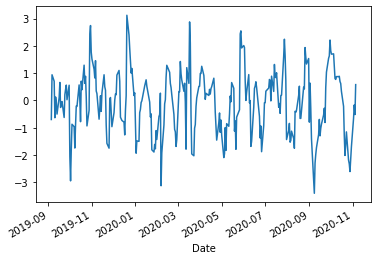

In [119]:
#Ploteamos el Z-Score
plt.figure() 
df.ZScore.plot() 
plt.show() 


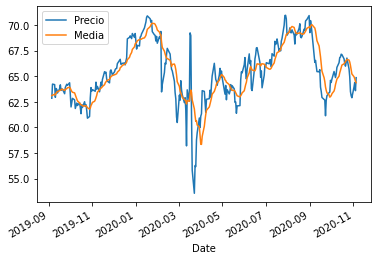

In [120]:
#Ploteamos la grafica de la empresa con la media 
plt.figure()
df.Close.plot(label='Precio')
df.SMA.plot(label='Media')
plt.legend()
plt.show()

In [121]:
df

,High,Low,Open,Close,Volume,Adj Close,percent_change,SMA,Spread,ZScore
Date,,,,,,,,,,
2019-09-05,63.759998,62.750000,63.709999,62.840000,1650400.0,60.674942,-0.007894,63.102000,-0.262000,-0.699026
2019-09-06,64.529999,63.840000,64.320000,64.220001,2645000.0,62.007393,0.021961,63.137000,1.083001,0.941701
2019-09-09,64.449997,63.610001,64.250000,64.169998,1559300.0,61.959118,-0.000779,63.229000,0.940998,0.706062
2019-09-10,64.169998,62.500000,63.849998,62.930000,3736700.0,60.761841,-0.019324,63.157000,-0.226999,-0.634867
2019-09-11,63.889999,62.630001,62.930000,63.790001,2149900.0,61.592216,0.013666,63.326000,0.464001,0.126583
...,...,...,...,...,...,...,...,...,...,...
2020-10-30,63.590000,62.560001,62.799999,62.889999,2532500.0,62.889999,-0.003012,65.212001,-2.322001,-1.704242
2020-11-02,64.599998,63.279999,63.759998,63.939999,1931500.0,63.939999,0.016696,64.937000,-0.997002,-0.665003
2020-11-03,65.489998,64.080002,64.410004,64.379997,1572700.0,64.379997,0.006881,64.750000,-0.370003,-0.164844


In [122]:
def señales(time_series):
    if time_series > entry_short: 
        return -1 
    elif time_series < entry_long: 
        return 1 
    else: 
        return 0        

df['Señal']=df['ZScore'].apply(lambda x: señales(x)) 
df['Strategy']= 0

In [123]:
for i in range(1,df.shape[0]-1): 
    
    #Abrir posicion de compra o venta
    if df['Strategy'].iloc[i-1]==0 and df['Señal'].iloc[i-1] != 0:
        df['Strategy'].iloc[i]=df['Señal'].iloc[i-1]
    
    #Cerrar posicion de compra
    elif df['ZScore'].iloc[i-1]>-0.25 and df['Strategy'].iloc[i-1]==1: 
        df['Strategy'].iloc[i]=0 
    #Cerrar posición de venta 
    elif df['ZScore'].iloc[i-1]<0.25 and df['Strategy'].iloc[i-1]==-1: 
        df['Strategy'].iloc[i]=0 
    else: 
        df['Strategy'].iloc[i]= df['Strategy'].iloc[i-1]
        
    
    


In [124]:
df.head(30)

,High,Low,Open,Close,Volume,Adj Close,percent_change,SMA,Spread,ZScore,Señal,Strategy
Date,,,,,,,,,,,,
2019-09-05,63.759998,62.750000,63.709999,62.840000,1650400.0,60.674942,-0.007894,63.102000,-0.262000,-0.699026,0,0
2019-09-06,64.529999,63.840000,64.320000,64.220001,2645000.0,62.007393,0.021961,63.137000,1.083001,0.941701,0,0
2019-09-09,64.449997,63.610001,64.250000,64.169998,1559300.0,61.959118,-0.000779,63.229000,0.940998,0.706062,0,0
2019-09-10,64.169998,62.500000,63.849998,62.930000,3736700.0,60.761841,-0.019324,63.157000,-0.226999,-0.634867,0,0
2019-09-11,63.889999,62.630001,62.930000,63.790001,2149900.0,61.592216,0.013666,63.326000,0.464001,0.126583,0,0
2019-09-12,64.459999,63.470001,64.459999,63.700001,1162000.0,61.505310,-0.001411,63.445000,0.255001,-0.070440,0,0
2019-09-13,63.970001,63.099998,63.250000,63.349998,1668500.0,61.167370,-0.005495,63.484000,-0.134002,-0.499411,0,0
2019-09-16,64.050003,63.049999,63.400002,63.779999,1574100.0,61.582558,0.006788,63.582000,0.197999,0.108860,0,0
2019-09-17,64.599998,63.700001,63.820000,64.150002,1714900.0,61.939808,0.005801,63.627000,0.523001,0.660778,0,0


In [125]:
#Calculamos los retornos de la estrategia
df['strategy_returns'] = df.percent_change * df.Strategy 

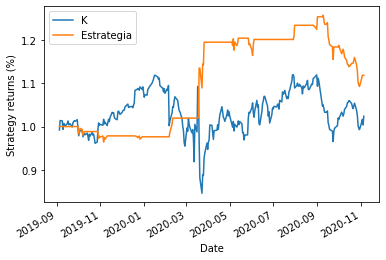

In [126]:
plt.figure()

(df.percent_change+1).cumprod().plot(label=ticker)
(df.strategy_returns+1).cumprod().plot(label='Estrategia')
plt.ylabel('Strategy returns (%)')
plt.legend()
plt.show()